## Carregamento e Inspeção Inicial dos Dados

Nesta seção, carrego os arquivos csv de treinamento, teste e de exempldo de submissão.


In [5]:
import pandas as pd

# Carrega os arquivos csv
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')

# Visualizar as primeiras linhas do conjunto de dados de treinamento
train_df.head()


,track_unique_id,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target
0,41996,7hUhmkALyQ8SX9mJs5XI3D,Love and Rockets,Love and Rockets,Motorcycle,211533,False,0.305,0.8490,9,...,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,0
1,76471,5x59U89ZnjZXuNAAlc8X1u,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",196000,False,0.287,0.1900,7,...,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,0
2,54809,70Vng5jLzoJLmeLu3ayBQq,Susumu Yokota,Symbol,Purple Rose Minuet,216506,False,0.583,0.5090,1,...,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,1
3,16326,1cRfzLJapgtwJ61xszs37b,Franz Liszt;YUNDI,Relajación y siestas,"Liebeslied (Widmung), S. 566",218346,False,0.163,0.0368,8,...,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0
4,109799,47d5lYjbiMy0EdMRV8lRou,Scooter,Scooter Forever,The Darkside,173160,False,0.647,0.9210,2,...,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,0


## Limpeza e Tratamento de Dados

Abaixo bsuco identificar e tratar valores nulos nas colunas do dataset. Esse passo é importante para garantir que o processamento do modelo não seja afetado por dados incompletos/sem uso.


In [6]:
# Verificar valores nulos no conjunto de dados de treino e teste
train_df.isnull().sum()
test_df.isnull().sum()

# Preencher valores nulos com "Unknown" em colunas categóricas
test_df['artists'].fillna('Unknown', inplace=True)
test_df['album_name'].fillna('Unknown', inplace=True)
test_df['track_name'].fillna('Unknown', inplace=True)


C:\Users\feber\AppData\Local\Temp\ipykernel_587340\106626987.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['artists'].fillna('Unknown', inplace=True)
C:\Users\feber\AppData\Local\Temp\ipykernel_587340\106626987.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

## Codificação de Variáveis Categóricas

As variáveis categóricas tem que ser transformadas para que possam ser usadas no modelo. Para isso, uso a técnica de Label Encoding


In [7]:
from sklearn.preprocessing import LabelEncoder

# label encoding de 'track_genre' e 'explicit'
label_encoder = LabelEncoder()

train_df['track_genre_encoded'] = label_encoder.fit_transform(train_df['track_genre'])
train_df['explicit_encoded'] = train_df['explicit'].astype(int)
test_df['track_genre_encoded'] = label_encoder.transform(test_df['track_genre'])
test_df['explicit_encoded'] = test_df['explicit'].astype(int)

# Verificar encoding
train_df[['track_genre', 'track_genre_encoded', 'explicit', 'explicit_encoded']].head()


,track_genre,track_genre_encoded,explicit,explicit_encoded
0,goth,41,False,0
1,opera,76,False,0
2,idm,54,False,0
3,classical,16,False,0
4,techno,109,False,0


## Análise Exploratória e Visualização

Análise da correlação entre as variáveis acústicas e a popularidade. Procuro encontrar algum padrão padrões que ajude a entender melhor o comportamento dos dados das músicas


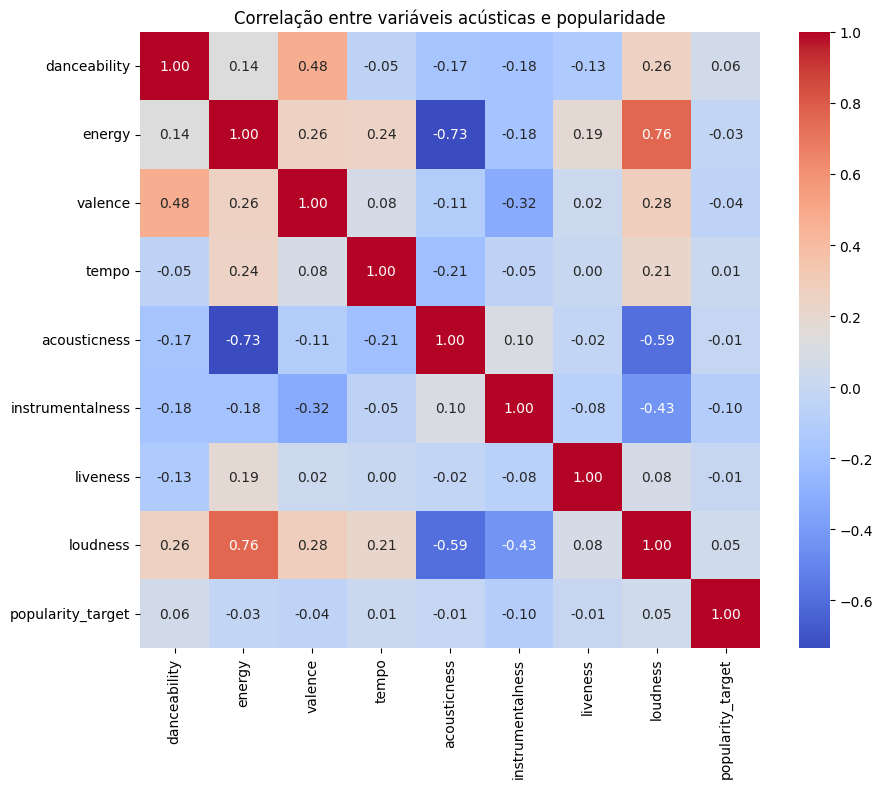

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de correlação entre as variáveis
corr_matrix = train_df[['danceability', 'energy', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'liveness', 'loudness', 'popularity_target']].corr()

# Plotar heatmap de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre variáveis acústicas e popularidade')
plt.show()


## Preparação dos Dados para o Modelo

Com base na análise exploratória, faço uma seleção das features mais relevantes para o modelo, como mostra a matriz acima. Também crio uma interação entre as variáveis `loudness` e `liveness` para encontrar melhor os efeitos no modelo. Me baseio em um estudo terceiro sobre a popularidade de músicas ao longo da história.


In [9]:
# interação entre 'loudness' e 'liveness'
train_df['loudness_liveness'] = train_df['loudness'] * train_df['liveness']
test_df['loudness_liveness'] = test_df['loudness'] * test_df['liveness']

# seleção de  features mais relevantes
features = ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'liveness', 'loudness', 'track_genre_encoded', 'explicit_encoded', 'loudness_liveness']

# divide o conjunto de dados para treinamento e validação
X_train = train_df[features]
y_train = train_df['popularity_target']
X_test = test_df[features]


## Treinamento e Avaliação do Modelo

Utilizo o modelo de Random Forest para avaliar o desempenho das relação de features selecionadas acima com métricas como acurácia, precisão e recall. O output demonstra estas métricas, e espera-se que sejam adequados à submissão do campeonato.


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Divide o conjunto de dados em treino e validação
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# roda o modelo
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_split, y_train_split)

# avaliação do modelo
y_val_pred = rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
classification_rep = classification_report(y_val, y_val_pred)

val_accuracy, classification_rep


(0.799937343358396,
 '              precision    recall  f1-score   support\n\n           0       0.81      0.80      0.81      8247\n           1       0.79      0.80      0.79      7713\n\n    accuracy                           0.80     15960\n   macro avg       0.80      0.80      0.80     15960\nweighted avg       0.80      0.80      0.80     15960\n')

## Geração de Previsões e Submissão

Uso o modelo criado e treinado para prever a popularidade no conjunto de teste. Após, o resultados de popularidade prevista são exibidos a partir do arquivo de submissão ao Kaggle gerado.


In [12]:
# Realiza predições no conjunto de teste
test_predictions = rf_model.predict(X_test)

# Cria o arquivo de submissão
submission = sample_submission_df.copy()
submission['popularity_target'] = test_predictions

# Salvar o arquivo csv no diretório atual
submission.to_csv('submission_final.csv', index=False)
